# ML Part

## Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import optuna

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Nadam

pd.set_option('display.max_columns', None)

## Common Preporcessing Steps

In [2]:
data = pd.read_csv('insurance.csv')
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [3]:
data.describe(include='all')

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


In [4]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
statistics = ['mean']

for i in statistics:
    result = data.groupby(['sex']).agg({'age': [i]})
    result.columns = [f'age_{i}_by_sex']
    result.reset_index(inplace=True)
    data = pd.merge(data, result, on='sex', how='left')

for i in statistics:
    result = data.groupby(['sex']).agg({'bmi': [i]})
    result.columns = [f'bmi_{i}_by_sex']
    result.reset_index(inplace=True)
    data = pd.merge(data, result, on='sex', how='left')

for i in statistics:
    result = data.groupby(['region']).agg({'age': [i]})
    result.columns = [f'age_{i}_by_region']
    result.reset_index(inplace=True)
    data = pd.merge(data, result, on='region', how='left')

for i in statistics:
    result = data.groupby(['region']).agg({'bmi': [i]})
    result.columns = [f'bmi_{i}_by_region']
    result.reset_index(inplace=True)
    data = pd.merge(data, result, on='region', how='left')

data

,age,sex,bmi,children,smoker,region,charges,age_mean_by_sex,bmi_mean_by_sex,age_mean_by_region,bmi_mean_by_region
0,19,female,27.900,0,yes,southwest,16884.92400,39.503021,30.377749,39.455385,30.596615
1,18,male,33.770,1,no,southeast,1725.55230,38.917160,30.943129,38.939560,33.355989
2,28,male,33.000,3,no,southeast,4449.46200,38.917160,30.943129,38.939560,33.355989
3,33,male,22.705,0,no,northwest,21984.47061,38.917160,30.943129,39.196923,29.199785
4,32,male,28.880,0,no,northwest,3866.85520,38.917160,30.943129,39.196923,29.199785
...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,38.917160,30.943129,39.196923,29.199785
1334,18,female,31.920,0,no,northeast,2205.98080,39.503021,30.377749,39.268519,29.173503
1335,18,female,36.850,0,no,southeast,1629.83350,39.503021,30.377749,38.939560,33.355989
1336,21,female,25.800,0,no,southwest,2007.94500,39.503021,30.377749,39.455385,30.596615


### Target

In [6]:
target = data['charges']

## Preporcessing for KNN

In [7]:
data_knn = data.copy()

In [8]:
inputs_knn = data_knn.drop('charges', axis=1)

In [9]:
inputs_knn = pd.get_dummies(inputs_knn, drop_first=True, dtype=int)
inputs_knn

,age,bmi,children,age_mean_by_sex,bmi_mean_by_sex,age_mean_by_region,bmi_mean_by_region,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,39.503021,30.377749,39.455385,30.596615,0,1,0,0,1
1,18,33.770,1,38.917160,30.943129,38.939560,33.355989,1,0,0,1,0
2,28,33.000,3,38.917160,30.943129,38.939560,33.355989,1,0,0,1,0
3,33,22.705,0,38.917160,30.943129,39.196923,29.199785,1,0,1,0,0
4,32,28.880,0,38.917160,30.943129,39.196923,29.199785,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,38.917160,30.943129,39.196923,29.199785,1,0,1,0,0
1334,18,31.920,0,39.503021,30.377749,39.268519,29.173503,0,0,0,0,0
1335,18,36.850,0,39.503021,30.377749,38.939560,33.355989,0,0,0,1,0
1336,21,25.800,0,39.503021,30.377749,39.455385,30.596615,0,0,0,0,1


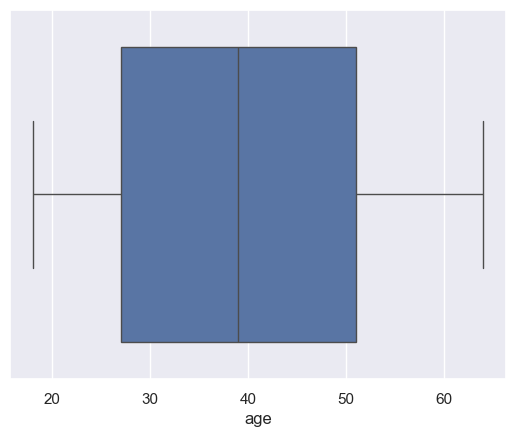

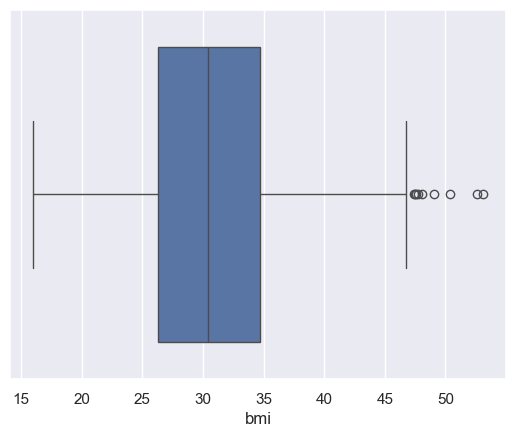

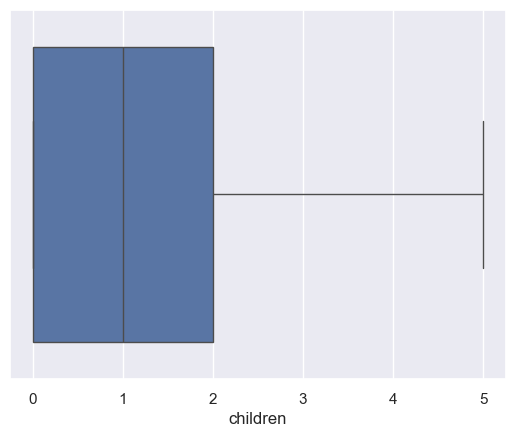

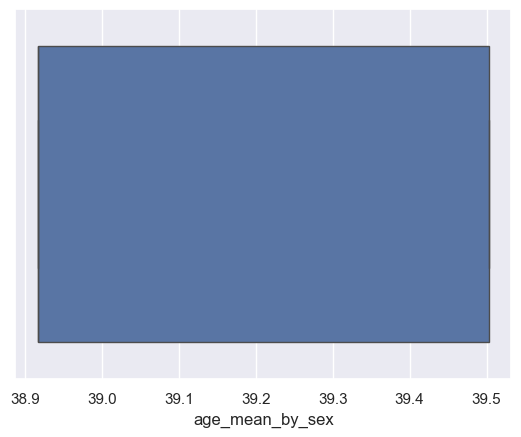

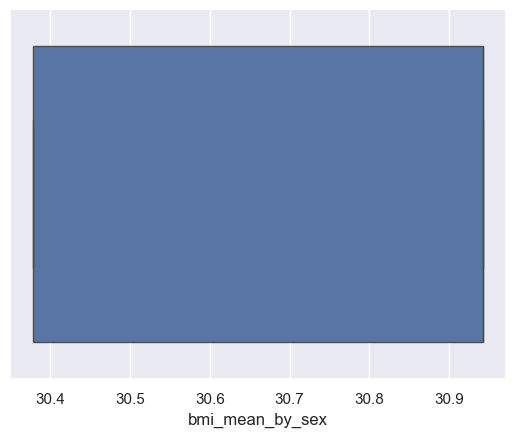

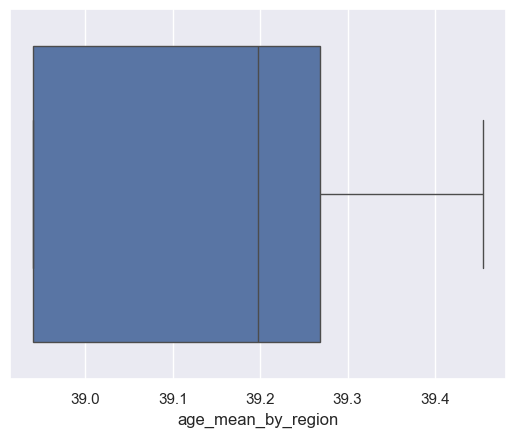

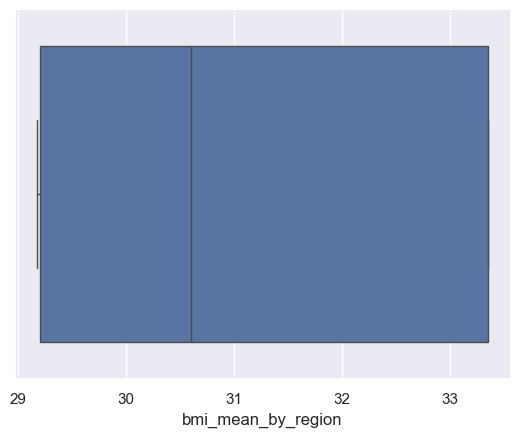

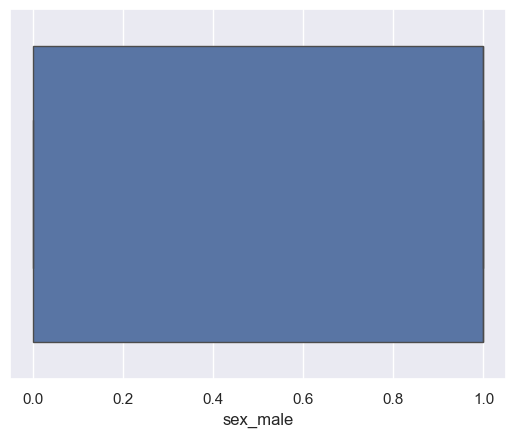

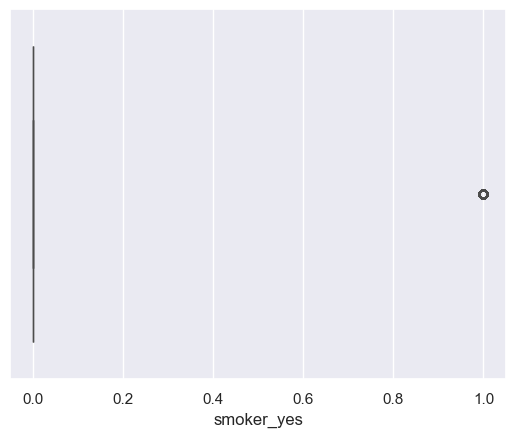

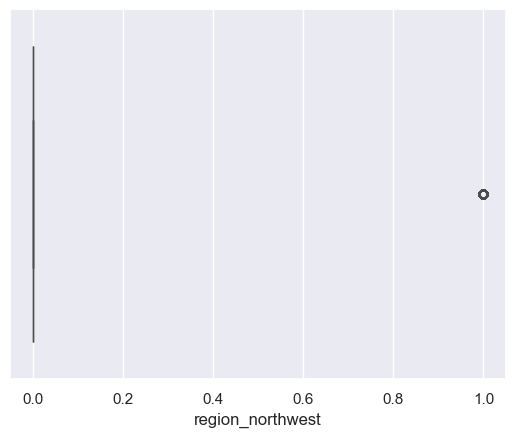

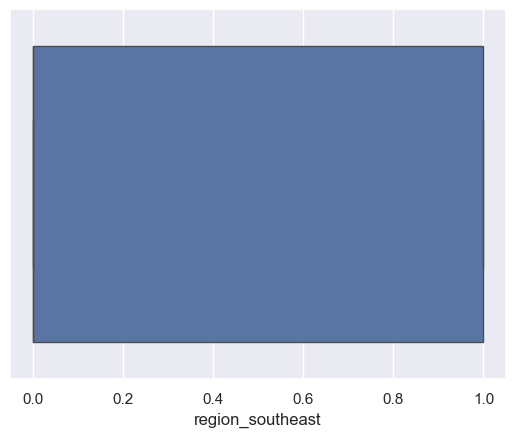

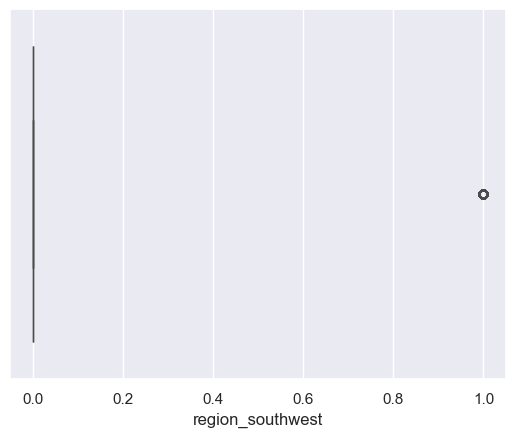

In [10]:
for i in inputs_knn.columns:
    if inputs_knn[i].dtypes != object:
        sns.boxplot(data=inputs_knn, x=inputs_knn[i])
        plt.show()

In [11]:
q1 = inputs_knn.quantile(0.25, numeric_only=True)
q3 = inputs_knn.quantile(0.75, numeric_only=True)
IQR = q3 - q1

Lower = q1 - 1.5 * IQR
Upper = q3 + 1.5 * IQR

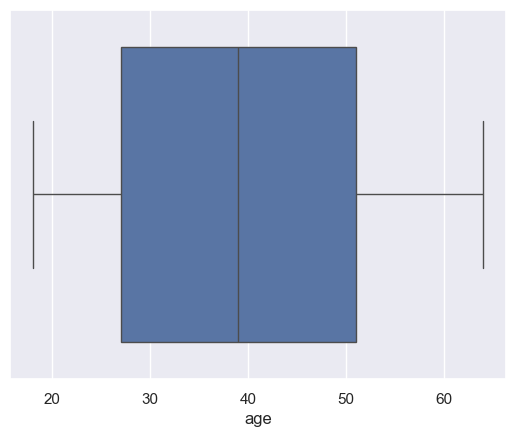

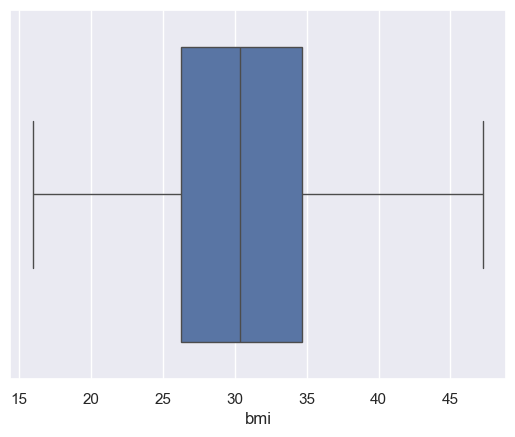

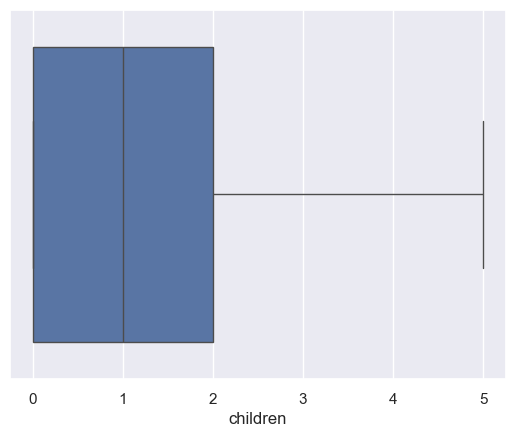

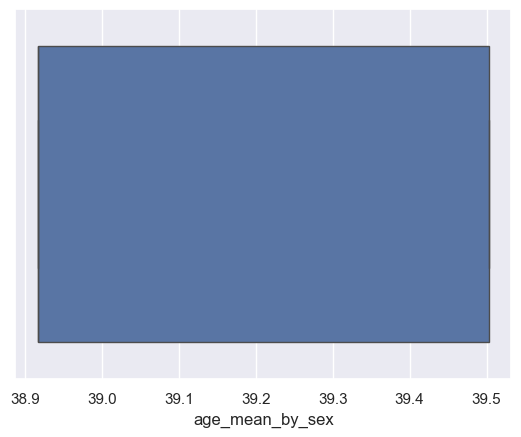

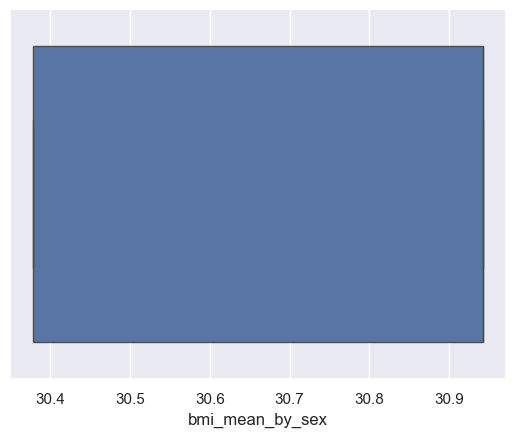

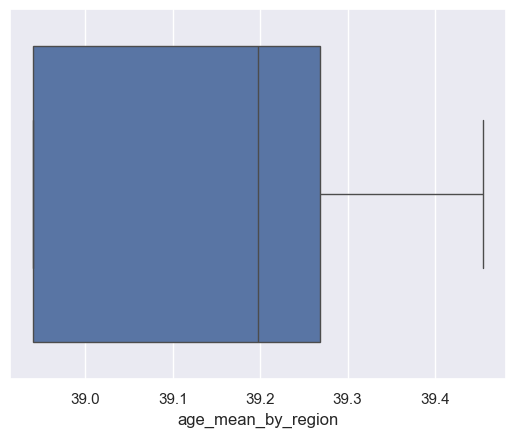

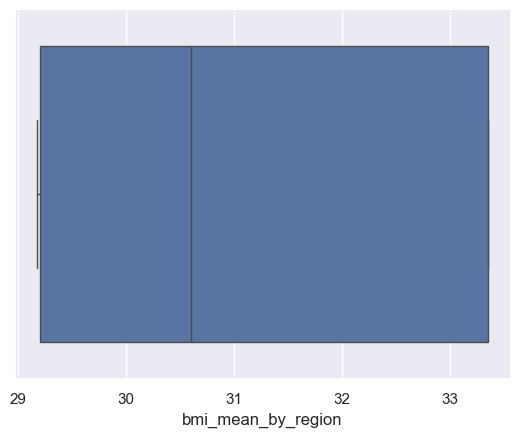

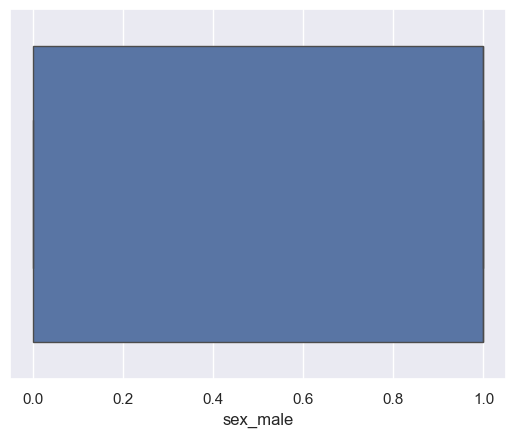

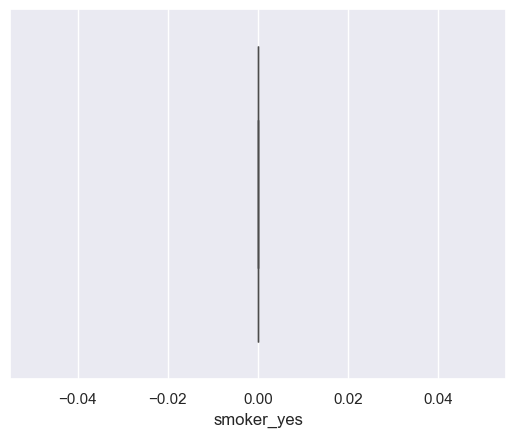

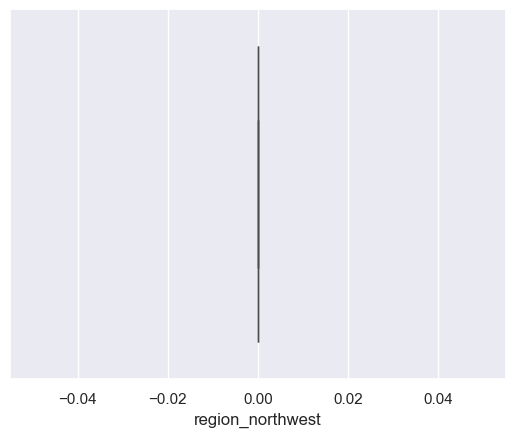

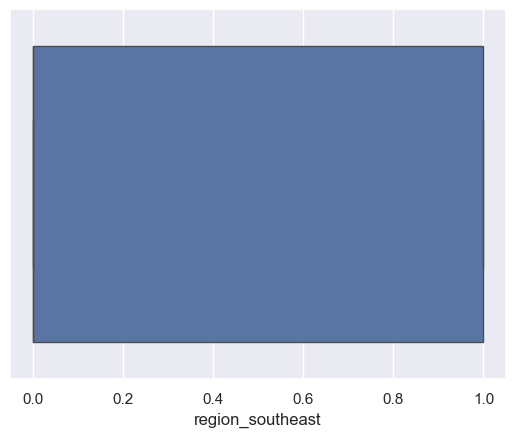

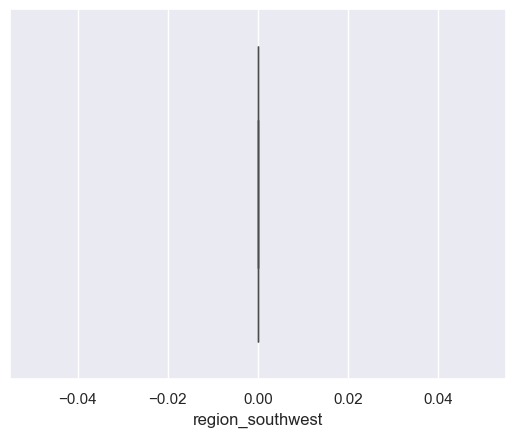

In [12]:
for i in inputs_knn.columns:
    if inputs_knn[i].dtypes != object:
        inputs_knn[i] = np.where(inputs_knn[i] > Upper[i], Upper[i], inputs_knn[i])
        inputs_knn[i] = np.where(inputs_knn[i] < Lower[i], Lower[i], inputs_knn[i])
        sns.boxplot(data=inputs_knn, x=inputs_knn[i])
        plt.show()

In [13]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(inputs_knn, target, test_size = 0.2, random_state = 42)

In [14]:
scaler = StandardScaler()

scaler.fit(X_train_knn)

X_train_knn_scaled = scaler.transform(X_train_knn)
X_test_knn_scaled = scaler.transform(X_test_knn)

X_train_knn = pd.DataFrame(X_train_knn_scaled, columns=X_train_knn.columns)
X_test_knn = pd.DataFrame(X_test_knn_scaled, columns=X_test_knn.columns)

## Preporcessing for Random Forest

In [15]:
data_rf = data.copy()

In [16]:
inputs_rf = data_rf.drop('charges', axis=1)

In [17]:
inputs_rf["sex"] = LabelEncoder().fit_transform(inputs_rf["sex"])
inputs_rf["smoker"]  = LabelEncoder().fit_transform(inputs_rf["smoker"])
inputs_rf["region"]      = LabelEncoder().fit_transform(inputs_rf["region"])

inputs_rf

,age,sex,bmi,children,smoker,region,age_mean_by_sex,bmi_mean_by_sex,age_mean_by_region,bmi_mean_by_region
0,19,0,27.900,0,1,3,39.503021,30.377749,39.455385,30.596615
1,18,1,33.770,1,0,2,38.917160,30.943129,38.939560,33.355989
2,28,1,33.000,3,0,2,38.917160,30.943129,38.939560,33.355989
3,33,1,22.705,0,0,1,38.917160,30.943129,39.196923,29.199785
4,32,1,28.880,0,0,1,38.917160,30.943129,39.196923,29.199785
...,...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1,38.917160,30.943129,39.196923,29.199785
1334,18,0,31.920,0,0,0,39.503021,30.377749,39.268519,29.173503
1335,18,0,36.850,0,0,2,39.503021,30.377749,38.939560,33.355989
1336,21,0,25.800,0,0,3,39.503021,30.377749,39.455385,30.596615


In [18]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(inputs_rf, target, test_size = 0.2, random_state = 42)

## Preporcessing for Gradient Boosting Models

In [19]:
data_boosting = data.copy()
data_boosting_cat = data.copy()

In [20]:
inputs_boosting = data_boosting.drop('charges', axis=1)
inputs_boosting_cat = data_boosting_cat.drop('charges', axis=1)

In [21]:
inputs_boosting = pd.get_dummies(inputs_boosting, drop_first=True, dtype=int)
inputs_boosting

,age,bmi,children,age_mean_by_sex,bmi_mean_by_sex,age_mean_by_region,bmi_mean_by_region,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,39.503021,30.377749,39.455385,30.596615,0,1,0,0,1
1,18,33.770,1,38.917160,30.943129,38.939560,33.355989,1,0,0,1,0
2,28,33.000,3,38.917160,30.943129,38.939560,33.355989,1,0,0,1,0
3,33,22.705,0,38.917160,30.943129,39.196923,29.199785,1,0,1,0,0
4,32,28.880,0,38.917160,30.943129,39.196923,29.199785,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,38.917160,30.943129,39.196923,29.199785,1,0,1,0,0
1334,18,31.920,0,39.503021,30.377749,39.268519,29.173503,0,0,0,0,0
1335,18,36.850,0,39.503021,30.377749,38.939560,33.355989,0,0,0,1,0
1336,21,25.800,0,39.503021,30.377749,39.455385,30.596615,0,0,0,0,1


In [22]:
X_train_boosting, X_test_boosting, y_train_boosting, y_test_boosting = train_test_split(inputs_boosting, target, test_size = 0.2, random_state = 42)

In [23]:
X_train_boosting_cat, X_test_boosting_cat, y_train_boosting_cat, y_test_boosting_cat = train_test_split(inputs_boosting_cat, target, test_size = 0.2, random_state = 42)

## Modeling

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test):
    try:
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        r2_test = metrics.r2_score(y_test, y_pred)

        y_pred_train = model.predict(X_train)

        r2_train = metrics.r2_score(y_train, y_pred_train)

        return [r2_train, r2_test]

    except Exception as e:
        print(f"An error occurred while evaluating the model {model_name}: {e}")
        return None

In [25]:
models = []

knn_def = KNeighborsRegressor()
rf_def = RandomForestRegressor(random_state=42)
xgb_def = XGBRegressor(random_state=42)
lgb_def = LGBMRegressor(random_state=42)
catboost_def = CatBoostRegressor(random_state=42)
catboost_cat_def = CatBoostRegressor(cat_features=["sex", "smoker", "region"], random_state=42)

models.extend([
    ("KNN Default", knn_def),
    ("RF Default", rf_def),
    ("XGBoost Default", xgb_def),
    ("LightGBM Default", lgb_def),
    ("CatBoost Default", catboost_def),
    ("CatBoost_cat Default", catboost_cat_def)
])

In [26]:
%%capture

R2_df = pd.DataFrame(columns=['Model', 'Train R2', 'Test R2'])

for model_name, model in models:
    if model_name == "KNN Default":
        r2_scores = train_and_evaluate_model(model_name, model, X_train_knn, y_train_knn, X_test_knn, y_test_knn)
    elif model_name == "RF Default":
        r2_scores = train_and_evaluate_model(model_name, model, X_train_rf, y_train_rf, X_test_rf, y_test_rf)
    elif model_name == "CatBoost_cat Default":
        r2_scores = train_and_evaluate_model(model_name, model, X_train_boosting_cat, y_train_boosting_cat, X_test_boosting_cat, y_test_boosting_cat)
    else:
        r2_scores = train_and_evaluate_model(model_name, model, X_train_boosting, y_train_boosting, X_test_boosting, y_test_boosting)

    if r2_scores is not None:
        R2_df = pd.concat([
            R2_df,
            pd.DataFrame({
                'Model': [model_name],
                'Train R2': [r2_scores[0]],
                'Test R2': [r2_scores[1]]
            })
        ], ignore_index=True)

R2_df_sorted = R2_df.sort_values(by='Test R2', ascending=False)

In [27]:
R2_df_sorted

,Model,Train R2,Test R2
5,CatBoost_cat Default,0.924077,0.873005
4,CatBoost Default,0.953211,0.866055
3,LightGBM Default,0.942749,0.864475
1,RF Default,0.974253,0.863223
2,XGBoost Default,0.994147,0.844515
0,KNN Default,0.290360,0.015874


## Hyperparameter Optimization Using Optuna

In [28]:
from sklearn.model_selection import cross_val_score

optuna.logging.set_verbosity(optuna.logging.WARNING)

def best_params_for_model(trial):
    param = {
    'n_neighbors': trial.suggest_int('n_neighbors', 1, 100), 
        
    'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),  
        
    'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),  
        
    'leaf_size': trial.suggest_int('leaf_size', 10, 120), 

    'p': trial.suggest_int('p', 1, 2),  
        
    'metric': trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan'])  

}

    knn_reg = KNeighborsRegressor(**param)

    accuracy = cross_val_score(knn_reg, X_train_knn, y_train_knn, cv=5, scoring='r2', n_jobs=-1).mean()
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=100)

print('Best trial:')
best_params = study.best_params
print('  Value: {:.3f}'.format(study.best_value))
print('  Params: ', best_params)

best_knn_model = KNeighborsRegressor(**best_params)

Best trial:
  Value: 0.085
  Params:  {'n_neighbors': 26, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 41, 'p': 2, 'metric': 'euclidean'}


In [29]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def best_params_for_model(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.5)
    }

    rf_reg = RandomForestRegressor(**param, random_state=42, n_jobs=-1)
    
    accuracy = cross_val_score(rf_reg, X_train_rf, y_train_rf, cv=3, scoring='r2', n_jobs=-1).mean()
    return accuracy


study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=100)

print('Best trial:')
best_params = study.best_params
print('  Value: {:.3f}'.format(study.best_value))
print('  Params: ', best_params)

best_rf_model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)

Best trial:
  Value: 0.850
  Params:  {'n_estimators': 429, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': None, 'bootstrap': True, 'min_impurity_decrease': 0.17161946490402075}


In [30]:
def best_params_for_model(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'num_leaves': trial.suggest_int('num_leaves', 10, 120)
    }

    lgb_reg = LGBMRegressor(**param, verbose=-1)

    accuracy = cross_val_score(lgb_reg, X_train_boosting, y_train_boosting, cv=3, scoring='r2', n_jobs=-1).mean()
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=100)

print('Best trial:')
best_params = study.best_params
print('  Value: {:.3f}'.format(study.best_value))
print('  Params: ', best_params)

best_lgb_model = LGBMRegressor(**best_params)

C:\Users\Chaos\AppData\Local\Temp\ipykernel_11536\101083054.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),


Best trial:
  Value: 0.851
  Params:  {'n_estimators': 375, 'learning_rate': 0.012138672577146195, 'max_depth': 3, 'num_leaves': 16}


In [31]:
def best_params_for_model(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_int('gamma', 0, 10),
        'verbosity': 0
    }

    xgb_reg = XGBRegressor(**param)
    accuracy = cross_val_score(
        xgb_reg, X_train_boosting, y_train_boosting,
        cv=3, scoring='r2', n_jobs=-1
    ).mean()
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=100, show_progress_bar=True)

print('Best trial:')
best_params = study.best_params
print('  Value: {:.3f}'.format(study.best_value))
print('  Params: ', best_params)

best_xgb_model = XGBRegressor(**best_params, verbosity=0)

  0%|          | 0/100 [00:00<?, ?it/s]

Best trial:
  Value: 0.853
  Params:  {'n_estimators': 178, 'learning_rate': 0.028123423140050192, 'max_depth': 3, 'subsample': 0.7785879393037876, 'colsample_bytree': 0.9493369955516108, 'gamma': 0}


In [32]:
def best_params_for_model(trial):

    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10), 
        'loss_function': trial.suggest_categorical('loss_function', ['RMSE']),
        'verbose': 0
    }

    cb_reg = CatBoostRegressor(**param)
    accuracy = cross_val_score(cb_reg, X_train_boosting, y_train_boosting, cv=3, scoring='r2', n_jobs=-1).mean()
    return accuracy


study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=100, show_progress_bar=True)

print('Best trial:')
best_params = study.best_params
print('  Value: {:.3f}'.format(study.best_value))
print('  Params: ', best_params)

best_cb_model = CatBoostRegressor(**best_params, verbose=0)

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\Chaos\AppData\Local\Temp\ipykernel_11536\2731615785.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\Chaos\AppData\Local\Temp\ipykernel_11536\2731615785.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10),


Best trial:
  Value: 0.853
  Params:  {'iterations': 723, 'learning_rate': 0.011607999323255841, 'depth': 3, 'l2_leaf_reg': 2.3536562251838853, 'loss_function': 'RMSE'}


In [33]:
models_optimized = []

models_optimized.extend([
    ('KNN Optuna', best_knn_model),
    ('RF Optuna', best_rf_model),
    ('XGBoost Optuna', best_xgb_model),
    ('LightGBM Optuna', best_lgb_model),
    ('CatBoost Optuna', best_cb_model)
])

In [34]:
results = []

for model_name, model in models_optimized:    
    if model_name == 'KNN Optuna':
        X_train, y_train, X_test, y_test = X_train_knn, y_train_knn, X_test_knn, y_test_knn
    elif model_name == 'RF Optuna':
        X_train, y_train, X_test, y_test = X_train_rf, y_train_rf, X_test_rf, y_test_rf
    else:
        X_train, y_train, X_test, y_test = X_train_boosting, y_train_boosting, X_test_boosting, y_test_boosting

    if 'XGBoost Optuna' in model_name:
        model.set_params(verbosity=0)
    elif 'CatBoost Optuna' in model_name:
        model.set_params(verbose=0)
    elif 'LightGBM Optuna' in model_name:
        model.set_params(verbose=-1)

    r2_scores = train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test)
    
    if r2_scores is not None:
        results.append({
            'Model': model_name,
            'Train R2': r2_scores[0],
            'Test R2': r2_scores[1]
        })

R2_df_sorted_optuna = pd.DataFrame(results).sort_values(by='Test R2', ascending=False)
R2_df_sorted_optuna

,Model,Train R2,Test R2
4,CatBoost Optuna,0.871084,0.883687
3,LightGBM Optuna,0.875482,0.882819
2,XGBoost Optuna,0.880119,0.882441
1,RF Optuna,0.871342,0.875635
0,KNN Optuna,0.151720,0.130868


In [35]:
final_review = pd.concat([R2_df_sorted, R2_df_sorted_optuna], axis=0)

final_review_sorted = final_review.sort_values(by='Test R2', ascending=False)
final_review_sorted.reset_index(drop=True, inplace=True)

final_review_sorted

,Model,Train R2,Test R2
0,CatBoost Optuna,0.871084,0.883687
1,LightGBM Optuna,0.875482,0.882819
2,XGBoost Optuna,0.880119,0.882441
3,RF Optuna,0.871342,0.875635
4,CatBoost_cat Default,0.924077,0.873005
5,CatBoost Default,0.953211,0.866055
6,LightGBM Default,0.942749,0.864475
7,RF Default,0.974253,0.863223
8,XGBoost Default,0.994147,0.844515
9,KNN Optuna,0.151720,0.130868


## Importance of variables

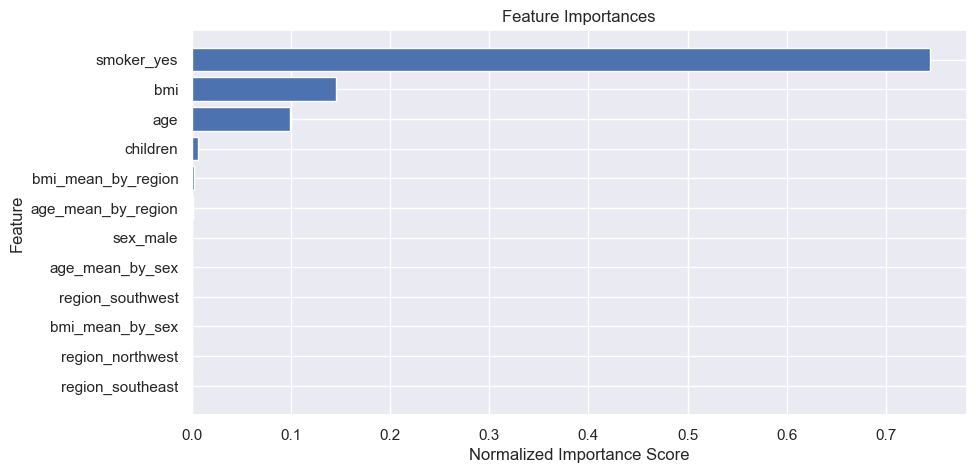

In [36]:
importances = best_cb_model.feature_importances_

importances = importances / importances.sum()

importance_df = pd.DataFrame({
    'Feature': X_train_boosting.columns,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title("Feature Importances")
plt.xlabel("Normalized Importance Score")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

In [37]:
threshold = 0.01

important_features_df = importance_df[importance_df["Importance"] > threshold]

print(f"Features with Importance > {threshold*100} %:")

important_features_df

Features with Importance > 1.0 %:


,Feature,Importance
8,smoker_yes,0.743696
1,bmi,0.145392
0,age,0.098790


In [38]:
important_features_df.Feature.tolist()

['smoker_yes', 'bmi', 'age']

SHAP Values Summary (Selected Features)


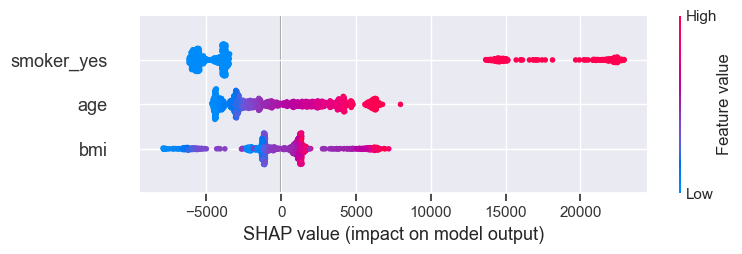

In [39]:
import shap

selected_features = ['smoker_yes', 'bmi', 'age']

explainer = shap.TreeExplainer(best_cb_model)
shap_values = explainer.shap_values(X_train_boosting)

shap_df = pd.DataFrame(shap_values, columns=X_train_boosting.columns)
shap_selected = shap_df[selected_features]
X_selected = X_train_boosting[selected_features]

print("SHAP Values Summary (Selected Features)")
plt.figure(figsize=(10, 5))
shap.summary_plot(shap_selected.values, X_selected, show=False)
plt.tight_layout()
plt.show()

In [40]:
fin_input = inputs_boosting[important_features_df['Feature'].tolist()]
fin_output = target

X_train_fin, X_test_fin, y_train_fin, y_test_fin = train_test_split(fin_input, fin_output, test_size=0.2, random_state=42)

In [41]:
def best_params_for_model(trial):

    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10), 
        'loss_function': trial.suggest_categorical('loss_function', ['RMSE']),
        'verbose': 0
    }

    cb_reg = CatBoostRegressor(**param)
    accuracy = cross_val_score(cb_reg, X_train_boosting, y_train_boosting, cv=3, scoring='r2', n_jobs=-1).mean()
    return accuracy


study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=100, show_progress_bar=True)

print('Best trial:')
best_params = study.best_params
print('  Value: {:.3f}'.format(study.best_value))
print('  Params: ', best_params)

best_cb_model_fin = CatBoostRegressor(**best_params, verbose=0)

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\Chaos\AppData\Local\Temp\ipykernel_11536\1637862471.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\Chaos\AppData\Local\Temp\ipykernel_11536\1637862471.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10),


Best trial:
  Value: 0.853
  Params:  {'iterations': 538, 'learning_rate': 0.01445258874884654, 'depth': 3, 'l2_leaf_reg': 3.7293192227477228, 'loss_function': 'RMSE'}


In [42]:
r2_train_fin, r2_test_fin = train_and_evaluate_model('Opitimized CatBoost with selected features', best_cb_model_fin, X_train_fin, y_train_fin, X_test_fin, y_test_fin)

In [43]:
print("Opitimized CatBoost with selected features")
print(f"R2 Train: {r2_train_fin * 100:.2f}")
print(f"R2 Test: {r2_test_fin * 100:.2f}")

Opitimized CatBoost with selected features
R2 Train: 86.27
R2 Test: 87.77


# DL Part

## Preprocessing for ANN

In [44]:
data_ann = data.copy()
data_ann

,age,sex,bmi,children,smoker,region,charges,age_mean_by_sex,bmi_mean_by_sex,age_mean_by_region,bmi_mean_by_region
0,19,female,27.900,0,yes,southwest,16884.92400,39.503021,30.377749,39.455385,30.596615
1,18,male,33.770,1,no,southeast,1725.55230,38.917160,30.943129,38.939560,33.355989
2,28,male,33.000,3,no,southeast,4449.46200,38.917160,30.943129,38.939560,33.355989
3,33,male,22.705,0,no,northwest,21984.47061,38.917160,30.943129,39.196923,29.199785
4,32,male,28.880,0,no,northwest,3866.85520,38.917160,30.943129,39.196923,29.199785
...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,38.917160,30.943129,39.196923,29.199785
1334,18,female,31.920,0,no,northeast,2205.98080,39.503021,30.377749,39.268519,29.173503
1335,18,female,36.850,0,no,southeast,1629.83350,39.503021,30.377749,38.939560,33.355989
1336,21,female,25.800,0,no,southwest,2007.94500,39.503021,30.377749,39.455385,30.596615


In [45]:
target_ann = data_ann['charges']
inputs_ann = data_ann.drop(['charges'], axis=1)

In [46]:
inputs_ann = pd.get_dummies(inputs_ann, drop_first=True, dtype=int)
inputs_ann

,age,bmi,children,age_mean_by_sex,bmi_mean_by_sex,age_mean_by_region,bmi_mean_by_region,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,39.503021,30.377749,39.455385,30.596615,0,1,0,0,1
1,18,33.770,1,38.917160,30.943129,38.939560,33.355989,1,0,0,1,0
2,28,33.000,3,38.917160,30.943129,38.939560,33.355989,1,0,0,1,0
3,33,22.705,0,38.917160,30.943129,39.196923,29.199785,1,0,1,0,0
4,32,28.880,0,38.917160,30.943129,39.196923,29.199785,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,38.917160,30.943129,39.196923,29.199785,1,0,1,0,0
1334,18,31.920,0,39.503021,30.377749,39.268519,29.173503,0,0,0,0,0
1335,18,36.850,0,39.503021,30.377749,38.939560,33.355989,0,0,0,1,0
1336,21,25.800,0,39.503021,30.377749,39.455385,30.596615,0,0,0,0,1


In [47]:
X_train_ann, X_test_ann, y_train_ann, y_test_ann = train_test_split(inputs_ann, target_ann, test_size=0.2, random_state=42)

In [48]:
scaler = StandardScaler()

scaler.fit(X_train_ann)

X_train_ann_scaled = scaler.transform(X_train_ann)
X_test_ann_scaled = scaler.transform(X_test_ann)

X_train_ann = pd.DataFrame(X_train_ann_scaled, columns=X_train_ann.columns)
X_test_ann = pd.DataFrame(X_test_ann_scaled, columns=X_test_ann.columns)

## Modeling (ANN)

In [49]:
def create_model(trial):
    model = Sequential()

    model.add(Dense(units=trial.suggest_int('units_layer1', 6, 32), activation='relu'))
    model.add(Dense(units=trial.suggest_int('units_layer2', 6, 32), activation='relu'))
    model.add(Dense(units=1, activation='linear'))

    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop', 'adagrad'])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    
    return model

In [51]:
def optimal(trial):
    
    epochs = trial.suggest_int('epochs', 20, 100)
    batch_size = trial.suggest_int('batch_size', 16, 128)
    
    model = create_model(trial)
    
    history = model.fit(
        X_train_ann, y_train_ann, 
        epochs=epochs, 
        batch_size=batch_size, 
        verbose=0
    )
    
    y_pred = model.predict(X_test_ann, verbose=0)
    accuracy = r2_score(y_test_ann, y_pred)
    
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(optimal, n_trials=20, show_progress_bar=True)

print(f"Best trial: {study.best_trial.value}")
print(f"Best hyperparameters: {study.best_trial.params}")

  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\Chaos\AppData\Local\Temp\ipykernel_11536\4200959821.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\Chaos\AppData\Local\Temp\ipykernel_11536\4200959821.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\Chaos\AppData\Local\Temp\ipykernel_11536\4200959821.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_logunifo

Best trial: 0.8021773342827029
Best hyperparameters: {'epochs': 59, 'batch_size': 20, 'units_layer1': 30, 'units_layer2': 18, 'optimizer': 'adam', 'learning_rate': 0.0019522724013968863}


In [52]:
best_params = study.best_trial.params
best_params

{'epochs': 59,
 'batch_size': 20,
 'units_layer1': 30,
 'units_layer2': 18,
 'optimizer': 'adam',
 'learning_rate': 0.0019522724013968863}

In [53]:
best_model = Sequential()
best_model.add(Dense(units=best_params['units_layer1'], activation='relu'))
best_model.add(Dense(units=best_params['units_layer2'], activation='relu'))
best_model.add(Dense(1, activation='linear'))

In [54]:
if best_params['optimizer'] == 'adam':
    best_optimizer = Adam(learning_rate=best_params['learning_rate'])
elif best_params['optimizer'] == 'sgd':
    best_optimizer = SGD(learning_rate=best_params['learning_rate'])
elif best_params['optimizer'] == 'rmsprop':
    best_optimizer = RMSprop(learning_rate=best_params['learning_rate'])
elif best_params['optimizer'] == 'adagrad':
    best_optimizer = Adagrad(learning_rate=best_params['learning_rate'])

In [55]:
best_model.compile(optimizer=best_optimizer, loss='mse', metrics=['mse'])

In [56]:
def evaluate(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
        
    y_train_pred = model.predict(X_train, verbose=0)
    y_test_pred = model.predict(X_test, verbose=0)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    results = pd.DataFrame({
        'Dataset': ['Train', 'Test'],
        'R2': [train_r2 * 100, test_r2 * 100]
    })

    return results

In [57]:
best_ann_result = evaluate(best_model, X_train_ann, y_train_ann, X_test_ann, y_test_ann)
best_ann_result

,Dataset,R2
0,Train,77.128615
1,Test,80.013632
